<a href="https://colab.research.google.com/github/MUYang99/Time-Series-Prediction-Based-on-Deep-Learning/blob/main/Multi_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import pandas as pd
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.optimizers import adam_v2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, explained_variance_score
from scipy import stats, arange
from matplotlib.pyplot import MultipleLocator

# Data Process

In [18]:
### Import data & dropna
df = pd.read_excel('d2.xlsx')
df = df.dropna()
print(df)

                      Date      NOx  Difftemp  ...   Temp     WD       WS
0      2015-01-01 00:15:00  62.2314    -0.070  ...  2.614  278.9  4.81599
1      2015-01-01 00:30:00  75.7350    -0.067  ...  2.685  280.9  4.63499
2      2015-01-01 00:45:00  70.4414    -0.070  ...  2.778  278.6  3.29300
5      2015-01-01 01:30:00  29.6205    -0.071  ...  3.279  292.5  5.41499
6      2015-01-01 01:45:00  53.4148    -0.092  ...  3.426  290.0  5.60100
...                    ...      ...       ...  ...    ...    ...      ...
210426 2020-12-31 22:45:00  11.7719    -0.221  ...  3.674  139.6  2.29500
210427 2020-12-31 23:00:00  25.4470    -0.225  ...  3.745  150.5  2.10400
210428 2020-12-31 23:15:00  34.3861    -0.212  ...  3.661  151.5  2.87800
210429 2020-12-31 23:30:00  47.5379    -0.195  ...  3.562  150.9  2.69900
210430 2020-12-31 23:45:00  65.7220    -0.249  ...  3.565  145.1  2.41100

[202485 rows x 10 columns]


(34063,)

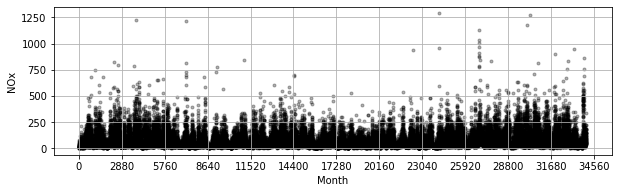

In [19]:
### Data selection(date)
data = df[df.Date < '20151231']
# data = df
data = data.drop(["Date"], axis=1)
nox = data.NOx.values
nox = nox.reshape(len(nox),)

fig = plt.figure(figsize = (10, 6))
ax1 = fig.add_subplot(2, 1, 1)
x  = np.arange(len(nox))
plt.scatter(x, nox, color = 'k', marker = '.', alpha = 0.3)

x_major_locator=MultipleLocator(4*24*30)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xlabel('Month')
plt.ylabel('NOx')
plt.grid()

nox.shape

In [20]:
### Average hour data
d1 = data.values
n = d1.shape[0]%4
m = int((d1.shape[0] - n)/4)
avg = np.zeros((m, d1.shape[1]))
for i in range(d1.shape[1]):
  di = d1[:,i].tolist()
  x = len(di)%4
  while x:
    di.pop()
    x -= 1
  arr = np.array(di).reshape(m, 4)
  temp = np.mean(arr, axis = 1)
  avg[:, i] = temp
avg

array([[ 5.95070750e+01, -6.94999250e-02,  4.99999000e-04, ...,
         2.83900000e+00,  2.82725000e+02,  4.53974250e+00],
       [ 3.34482250e+01, -2.40249975e-01,  7.49998500e-04, ...,
         3.29125000e+00,  2.84875000e+02,  5.60925000e+00],
       [ 2.81088500e+01, -4.06500000e-01,  0.00000000e+00, ...,
         2.86075000e+00,  2.82900000e+02,  6.08050000e+00],
       ...,
       [ 7.21539000e+01, -8.47499500e-02,  0.00000000e+00, ...,
         1.80775000e+00,  2.10925000e+02,  4.40874750e+00],
       [ 7.39727750e+01, -8.67499250e-02,  0.00000000e+00, ...,
         1.71150000e+00,  2.07150000e+02,  4.02774500e+00],
       [ 4.95815750e+01, -9.32499750e-02,  0.00000000e+00, ...,
         1.70575000e+00,  2.07450000e+02,  4.81224750e+00]])

(8515,)


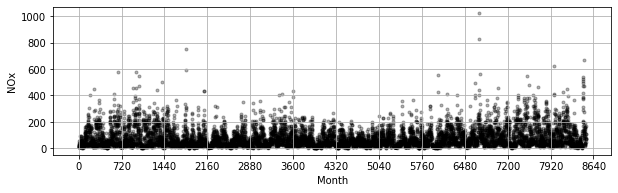

In [21]:
### NOx hour data
fig = plt.figure(figsize = (10, 6))
ax2 = fig.add_subplot(2, 1, 1)
x  = np.arange(avg.shape[0])
plt.scatter(x, avg[:, 0], color = 'k', marker = '.', alpha = 0.3)

x_major_locator=MultipleLocator(24*30)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xlabel('Month')
plt.ylabel('NOx')
plt.grid()

print(avg[:,0].shape)

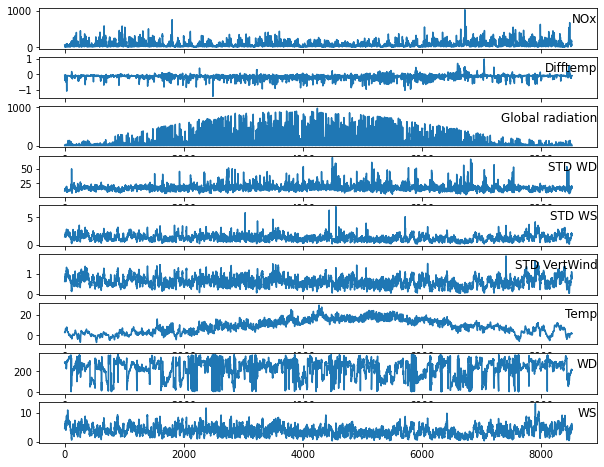

In [22]:
### All data
groups = [0,1,2,3,4,5,6,7,8]
i = 1
# plot each column
plt.figure(figsize = (10, 8))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(avg[:, group])
	plt.title(df.columns[group+1], y=0.5, loc='right')
	i += 1
plt.show()

In [23]:
### Data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(avg)

data.shape

(8515, 9)

# Build dataset

In [24]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

n_lag = 5
n_features = 9
reframed = series_to_supervised(data, n_lag, 1)
reframed.drop(reframed.columns[[46,47,48,49,50,51,52,53]], axis=1, inplace=True)
reframed.head()

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var9(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var7(t-4),var8(t-4),var9(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var1(t)
5,0.056084,0.565795,5.140057e-07,0.109930,0.194870,0.315667,0.271125,0.787398,0.331487,0.030502,0.494351,7.710085e-07,0.115225,0.221852,0.394481,0.283656,0.793448,0.414621,0.025261,0.424791,0.000000e+00,0.103693,0.217485,0.405409,0.271728,0.787891,0.451252,0.033897,0.551883,2.570028e-07,0.110205,0.231438,0.427400,0.269740,0.790283,0.439048,0.008300,0.556904,0.000000e+00,0.130680,0.224628,0.417156,0.270204,0.786132,0.411298,0.013022
6,0.030502,0.494351,7.710085e-07,0.115225,0.221852,0.394481,0.283656,0.793448,0.414621,0.025261,0.424791,0.000000e+00,0.103693,0.217485,0.405409,0.271728,0.787891,0.451252,0.033897,0.551883,2.570028e-07,0.110205,0.231438,0.427400,0.269740,0.790283,0.439048,0.008300,0.556904,0.000000e+00,0.130680,0.224628,0.417156,0.270204,0.786132,0.411298,0.013022,0.558264,2.570028e-07,0.147430,0.228551,0.417566,0.269740,0.774594,0.355603,0.006672
7,0.025261,0.424791,0.000000e+00,0.103693,0.217485,0.405409,0.271728,0.787891,0.451252,0.033897,0.551883,2.570028e-07,0.110205,0.231438,0.427400,0.269740,0.790283,0.439048,0.008300,0.556904,0.000000e+00,0.130680,0.224628,0.417156,0.270204,0.786132,0.411298,0.013022,0.558264,2.570028e-07,0.147430,0.228551,0.417566,0.269740,0.774594,0.355603,0.006672,0.557531,5.140057e-07,0.133701,0.235917,0.448299,0.266332,0.766433,0.403661,0.005112
8,0.033897,0.551883,2.570028e-07,0.110205,0.231438,0.427400,0.269740,0.790283,0.439048,0.008300,0.556904,0.000000e+00,0.130680,0.224628,0.417156,0.270204,0.786132,0.411298,0.013022,0.558264,2.570028e-07,0.147430,0.228551,0.417566,0.269740,0.774594,0.355603,0.006672,0.557531,5.140057e-07,0.133701,0.235917,0.448299,0.266332,0.766433,0.403661,0.005112,0.563912,4.769982e-04,0.136250,0.216189,0.411009,0.272857,0.778252,0.387124,0.005126
9,0.008300,0.556904,0.000000e+00,0.130680,0.224628,0.417156,0.270204,0.786132,0.411298,0.013022,0.558264,2.570028e-07,0.147430,0.228551,0.417566,0.269740,0.774594,0.355603,0.006672,0.557531,5.140057e-07,0.133701,0.235917,0.448299,0.266332,0.766433,0.403661,0.005112,0.563912,4.769982e-04,0.136250,0.216189,0.411009,0.272857,0.778252,0.387124,0.005126,0.563703,5.440239e-03,0.157197,0.244171,0.438738,0.290659,0.757217,0.377038,0.004333


In [25]:
values = reframed.values
n_val_hours = 3*24
train = values[:-n_val_hours, :]
test = values[-n_val_hours:,:]

train_X, train_y = train[:-n_lag, :-1], train[:-n_lag, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], n_lag, n_features))
test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8433, 5, 9) (8433,) (72, 5, 9) (72,)


# LSTM Construction & Training

In [26]:
### Configure
lr = 1e-4
n_epochs = 300
batchsize = 128
n_neuron = 150

In [27]:
### Contruct the LSTM
def build_lstm():

  model = Sequential()
  # model.add(LSTM(n_neuron, input_shape=(n_in, n_features)))
  model.add(LSTM(n_neuron, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
  model.add(LSTM(100, return_sequences=False))
  model.add(Dropout(0.2))
  model.add(Dense(1))
  #model.add(Activation("sigmoid"))
  model.compile(optimizer=adam_v2.Adam(learning_rate=lr), loss='mae')

  return model

Epoch 1/300
66/66 [==============================] - 6s 49ms/step - loss: 0.0518 - val_loss: 0.1116
Epoch 2/300
66/66 [==============================] - 3s 40ms/step - loss: 0.0447 - val_loss: 0.0973
Epoch 3/300
66/66 [==============================] - 3s 39ms/step - loss: 0.0412 - val_loss: 0.0848
Epoch 4/300
66/66 [==============================] - 3s 40ms/step - loss: 0.0384 - val_loss: 0.0769
Epoch 5/300
66/66 [==============================] - 3s 39ms/step - loss: 0.0370 - val_loss: 0.0746
Epoch 6/300
66/66 [==============================] - 3s 39ms/step - loss: 0.0362 - val_loss: 0.0732
Epoch 7/300
66/66 [==============================] - 3s 40ms/step - loss: 0.0360 - val_loss: 0.0723
Epoch 8/300
66/66 [==============================] - 3s 39ms/step - loss: 0.0357 - val_loss: 0.0718
Epoch 9/300
66/66 [==============================] - 3s 39ms/step - loss: 0.0352 - val_loss: 0.0715
Epoch 10/300
66/66 [==============================] - 3s 41ms/step - loss: 0.0347 - val_loss: 0.0710

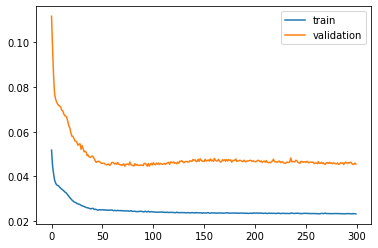

In [28]:
### Training LSTM
def model_fit(x_train, y_train, x_val, y_val):
    
    model = build_lstm()

    my_callbacks = [ModelCheckpoint(filepath='my_model.h5', save_best_only=True)]
    # my_callbacks = [EarlyStopping(patience=100), ModelCheckpoint(filepath='my_model.h5', save_best_only=True), ReduceLROnPlateau(factor = 0.1, patience = 50)]
    history = model.fit(x_train, y_train, batch_size=batchsize, epochs=n_epochs, verbose=1, callbacks=my_callbacks, validation_data=(x_val, y_val))
    # history = model.fit(x_train, y_train, batch_size=batchsize, epochs=n_epochs, verbose=1, validation_data=(x_val, y_val))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    plt.show()
    
    return model

model = model_fit(train_X, train_y, test_X, test_y)
model = load_model('my_model.h5')

# Results visualization & Analysis

In [29]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_lag*n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -8:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
Prediction = inv_yhat[:,0]

In [30]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -8:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
Truth = inv_y[:,0]

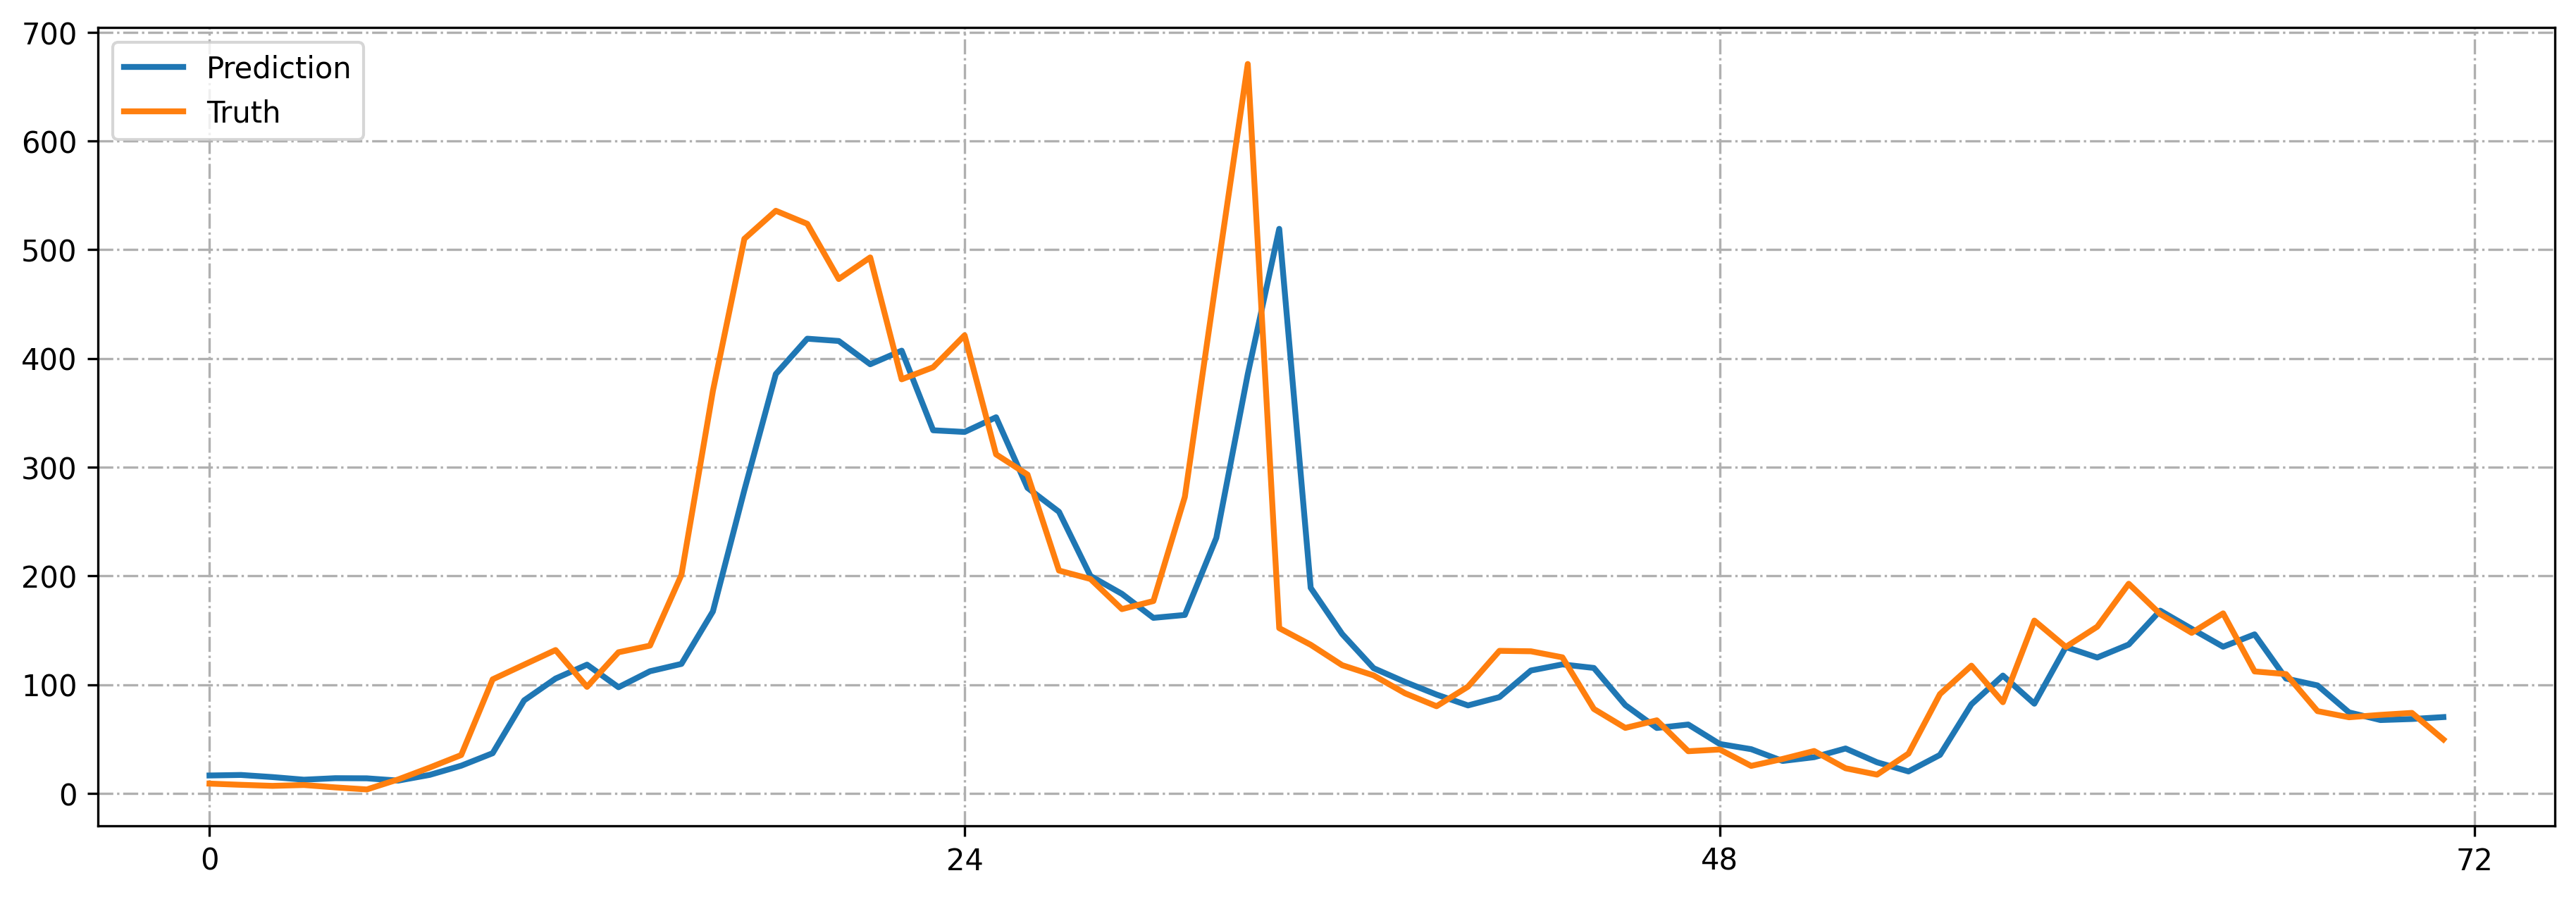

In [31]:
### Visualization
x = [x for x in range(n_val_hours)]
fig, ax = plt.subplots(figsize=(15,5), dpi = 300)
ax.plot(x, Prediction, linewidth=2.0, label = "Prediction")
ax.plot(x, Truth, linewidth=2.0, label = "Truth")

x_major_locator=MultipleLocator(24)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)

ax.legend(loc=2);
plt.grid(linestyle='-.')
plt.show()

In [36]:
### Analysis
MSE = mean_squared_error(Truth, Prediction)
RMSE = np.sqrt(MSE)
print('RMSE: %.3f' %RMSE)
MAE = mean_absolute_error(Truth, Prediction)
print('MAE: %.3f' %MAE)
MAPE = np.mean(np.abs((Truth - Prediction) / Truth)) * 100
print('MAPE: %.3f' %MAPE)
MedAE = median_absolute_error(Truth, Prediction)
print('MedAE: %.3f' %MedAE)
r2_score = r2_score(Truth, Prediction)
print('r2_score: %.3f' %r2_score)
explained_variance_score = explained_variance_score(Truth, Prediction)
print('explained_variance_score: %.3f' %explained_variance_score)

RMSE: 82.154
MAE: 45.409
MAPE: 37.925
MedAE: 20.731
r2_score: 0.712
explained_variance_score: 0.729
